In [140]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

torch.cuda.is_available()

True

# Dataset Class

In [141]:
# create a class to get the data set
class DataSet():
    def __init__(self, f_name='card_df.pickle', size=8000, dim=1, train_size = 0.75):
        df = pd.read_pickle(f_name)

        # remove all two-sided cards for now
        find_two_sided = lambda st: st.find(r'//')
        idx = np.array(df['CardName'].apply(find_two_sided) == -1)
        tdf = df.loc[idx]

        # make sure to get rid of nans
        price_nans = tdf.isna().sum()['Price']
        if price_nans > 0:
            tdf['Price'] = tdf['Price'].fillna(tdf['Price'].median())

        # make sure size is small enough
        assert size <= len(tdf), f"size must be less that {len(tdf)}; got {size}"
        # ensure only dim 1
        assert dim in [1,3], "Dimension must be 1 (flat) or 3 (RGB Channels)"

        if dim == 1:
            # create train/test tensors of len size (normally 6000/2000)
            TENSOR_LEN = 995520
            df = tdf.sample(size) # shuffle the data frame
            data = torch.empty((size, TENSOR_LEN))
            target = torch.empty((size, 1))
            for i in range(size):
                row = df.iloc[i]
                target[i] = float(row['Price'])
                name = row['CardName']

                # loop to ensure we get data
                fail = True
                while fail:
                    try:
                        card = torch.Tensor(self.get_image(name, dim=dim))
                        fail = False
                    except:
                        row = tdf.sample(1)
                        target[i] = float(row['Price'].values[0])
                        name = row['CardName'].values[0]
                        continue
                
                data[i, :] = card

            # split into train/test
            all_data = torch.hstack([data, target])
            split_idx = int(size * train_size)
            self.train = all_data[:split_idx]
            self.test = all_data[split_idx:]

        if dim == 3:
            loop = tqdm(total = size, position=0, leave=False)
            # get the shape of the image
            c, h, w = 3, 680, 488
            df = tdf.sample(size)
            data = torch.empty((size, c, h, w))
            target = torch.empty((size, 1))

            # fill data
            for i in range(size):
                row = df.iloc[i]
                target[i] = row['Price']
                name = row['CardName']

                # loop to ensure we get data
                fail = True
                while fail:
                    try:
                        card = torch.Tensor(self.get_image(name, dim=dim))
                        loop.update()
                        fail = False
                    except:
                        row = tdf.sample(1)
                        target[i] = row['Price'].values[0]
                        name = row['CardName'].values[0]

                data[i, :] = card.permute(2, 0, 1)

            split_idx = int(size * train_size)
            self.X_train, self.X_test = data[:split_idx], data[split_idx:]
            self.y_train, self.y_test = target[:split_idx], target[split_idx:]

    def get_image(self, card_name, dim=1):
        path = 'cards/' + card_name +'.png'
        img = Image.open(path)
        img = np.array(img)

        # return the array in the requested dimensions
        if dim == 3:
            return img
        elif dim == 2:
            m,n,l = img.shape
            return img.reshape(m*n, l)
        elif dim == 1:
            return img.flatten()
        else:
            raise ValueError(f"dim must be 1, 2, or 3; got {dim}")

In [142]:
# load the data, get train/test
data = DataSet(size=1000, dim=3)
X_train, X_test, y_train, y_test = data.X_train, data.X_test, data.y_train, data.y_test

/tmp/ipykernel_5494/2835197217.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['Price'] = tdf['Price'].fillna(tdf['Price'].median())


# Set up the Model

In [143]:
# the first model
class Aleph(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(995520, 256),
            nn.ReLU(),
            nn.Linear(256, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.ReLU(),
            nn.Linear(6, 1)
        )
    
    def forward(self, input):
        out = self.model(input)
        return out

In [176]:
# the second model
class Beit(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 25, 10),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(25, 9, 1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Linear(53, 1),
            # nn.ReLU(),
            # nn.Linear(96, 24),
            # nn.ReLU(),
            # nn.Linear(24,1)
        )
    
    def forward(self, input):
        out = self.model(input)
        return out

In [177]:
model = Beit()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [178]:
# cuda everything
model = model.to('cuda')

In [179]:
n_epochs = len(X_train)
num_checks = 100
check_every = n_epochs // num_checks
loop = tqdm(total=n_epochs + (len(X_test) * num_checks), position=0, leave=False)
total_found = n_epochs

loss_train_list = list()
loss_val_list = list()

# training loop
for epoch in range(n_epochs):
    model.train()

    # get the data
    card = X_train[epoch].cuda(non_blocking=True)
    y_truth = y_train[epoch].cuda(non_blocking=True)

    # forward pass
    y_ = model(card)

    loss = loss_func(y_, y_truth)
    loss_train_list.append(float(loss))

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()

    # progress
    loop.set_description(f"Loss:\t{round(loss.item(), 4)}")
    loop.update()

    # check progress
    if epoch % check_every == 0 or epoch == n_epochs - 1:
        model.eval()
        mse_list = list()

        for i in range(len(X_test)):
            card = X_test[i].cuda(non_blocking=True)
            y_truth = y_test[i].cuda(non_blocking=True)

            # prediction
            pred = model(card)

            # get loss
            mse = float(loss_func(pred, y_truth))
            mse_list.append(mse)
            loop.update()

        loss_val_list.append(np.mean(mse_list))


/home/banhaty/miniconda3/envs/mtg/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([9, 74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Loss:	0.7086: : 27747it [01:21, 350.87it/s]                             

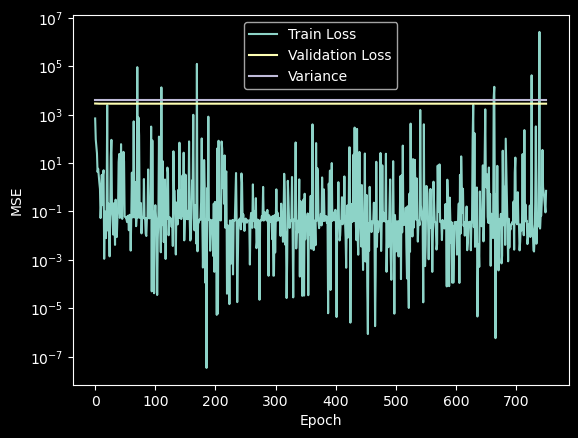

In [180]:
plt.style.use("dark_background")
tx = np.linspace(0, n_epochs, len(loss_train_list))
vx = np.linspace(0, n_epochs  , len(loss_val_list))
plt.semilogy(tx, loss_train_list, label='Train Loss')
plt.semilogy(vx, loss_val_list, label='Validation Loss')
plt.semilogy([0, tx[-1]], [y_train.var().item() for i in range(2)], label="Variance")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

Since the validation MSE is higher than the variance of the test set, we know that this model is not performing better than just predicting the mean.

# Visualize Feature Maps

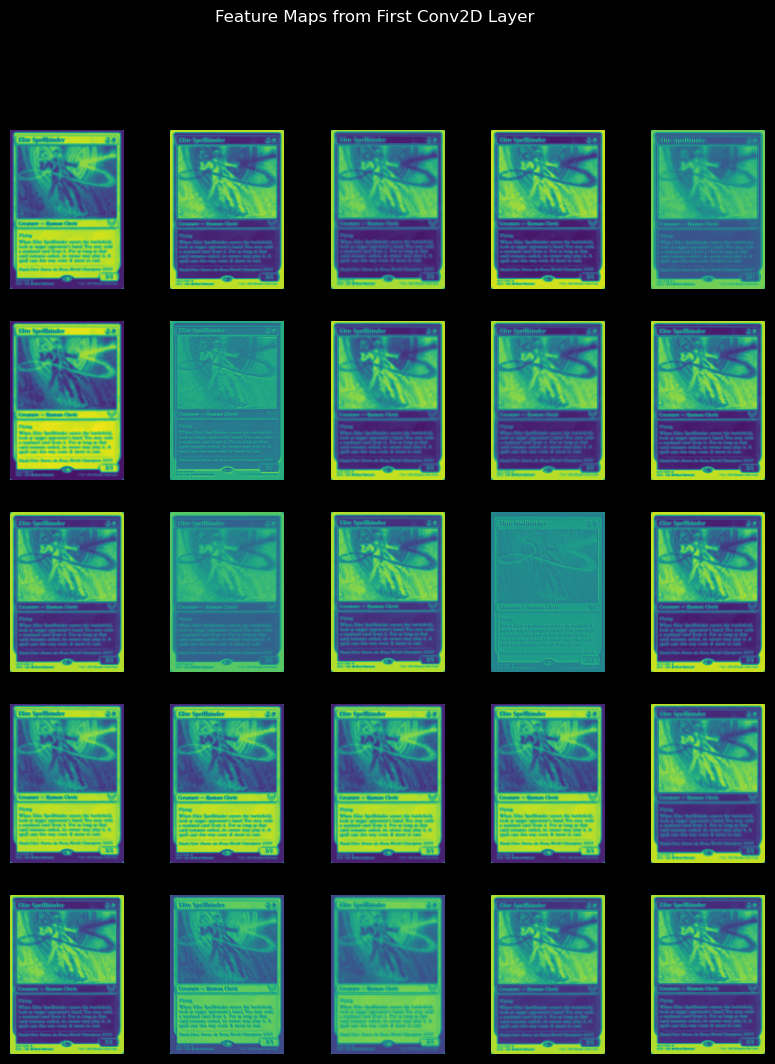

In [181]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook

model.model[0].register_forward_hook(get_activation('model'))
card = X_test[0].cuda()
output = model(card)

act = activation['model'].squeeze()
sq = 5
fig, ax = plt.subplots(sq,sq, figsize=(10,12))
for idx in range(act.size(0)):
    idx1 = idx // sq
    idx2 = idx - sq*idx1
    ax[idx1, idx2].imshow(act[idx].cpu())
    ax[idx1, idx2].axis('off')
plt.suptitle("Feature Maps from First Conv2D Layer")
plt.show()



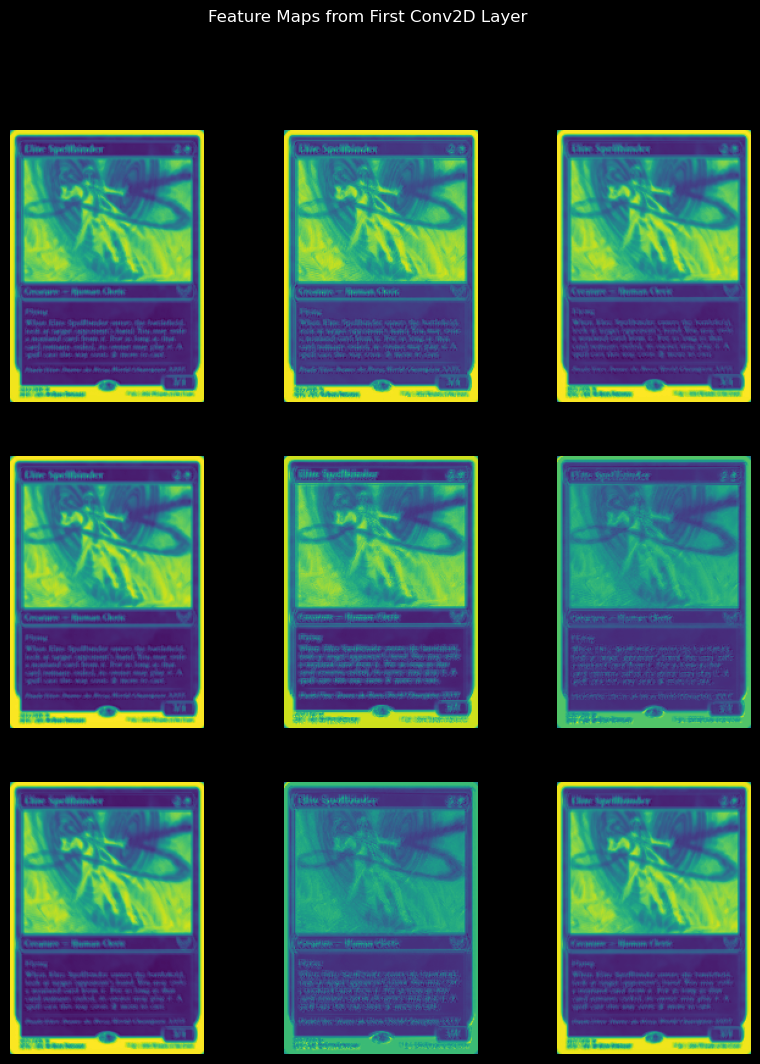

Loss:	0.7086: : 27750it [01:31, 350.87it/s]

In [182]:
activation2 = {}
def get_activation(name):
    def hook(model, input, output):
        activation2[name] = output.detach()

    return hook

model.model[3].register_forward_hook(get_activation('model'))
card = X_test[0].cuda()
output = model(card)

act = activation2['model'].squeeze()
sq = 3
fig, ax = plt.subplots(sq,sq, figsize=(10,12))
for idx in range(act.size(0)):
    idx1 = idx // sq
    idx2 = idx - sq*idx1
    ax[idx1, idx2].imshow(act[idx].cpu())
    ax[idx1, idx2].axis('off')
plt.suptitle("Feature Maps from First Conv2D Layer")
plt.show()